## Bayesian estimation of enzyme elasticities for an in vitro pathway

This notebook is derived from Wu2004.ipynb. 
Wu2004.ipynb uses a model and data from C. Giersch, European Journal of Biochemistry. 227, 194–201 (1995). 
However, instead of running just one model, this notebook will run analysis for a batch of models. 
This notebook is designed to run within the framework of the following files:
- `generating_synthetic_models.ipynb`
- `generated_model_analysis.ipynb`


In [1]:
# handy-dandy
import os
import sys
from tqdm import tqdm
import warnings
# warnings.filterwarnings("error")
# warnings.resetwarnings()
warnings.filterwarnings('ignore')

# arrays/dataframes
import numpy as np
np.random.seed(0)
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
pd.set_option
('display.max_columns', None)
pd.set_option('display.max_rows', None)

# math/stats
import scipy
import scipy.stats
import pymc as pm
import aesara
import arviz as az

# biochemical pathway simulators
import cobra
import tellurium as te

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

# linlog Bayesian Metabolic Control Analysis
import emll
from emll.util import initialize_elasticity

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
import sbb_10sp_alldata as ba
# ba.testImport()
FOLDER_NAME = '10sp/'

with open(FOLDER_NAME + "passlist.txt") as file:
    passlist = [line.rstrip() for line in file]

DATA_OMISSION_CODE = 'A'
ADVI_ITERATIONS = 1000 # 30000

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19


Adding exchange reaction EX_B8 with default bounds for boundary metabolite: B8.
Adding exchange reaction EX_B9 with default bounds for boundary metabolite: B9.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J0>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J0>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J1>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J1>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J5>'
Missing upper flux bound set to '1000.0' for reaction

Finished [100%]: Average Loss = 1.8501e+10


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

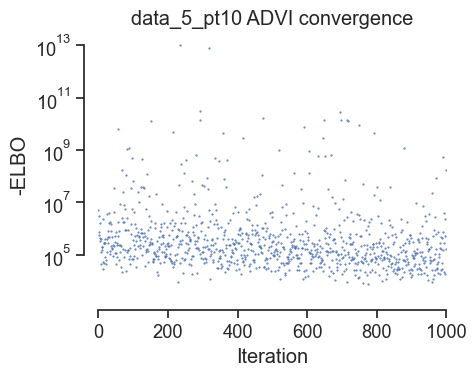

In [3]:
short = [['data_5_pt10.csv', 'data_5_pt50.csv']]
passN = 5
for data in short[0]: 
    path = f'test_{passN}.xml'
    ba.run_analysis(path, data, itr=ADVI_ITERATIONS, folder_name=FOLDER_NAME)
    # ba.labelData(r, model, FOLDER_NAME +  data)

In [5]:
path = 'test_5.xml'
dataPath = 'data_5_pt10.csv'
folder_name = FOLDER_NAME
itr = ADVI_ITERATIONS

In [6]:
r = te.loads(folder_name + 'sbml/' + path)
model = cobra.io.read_sbml_model(folder_name + 'sbml/' + path)

ex_list = [i.id for i in list(model.reactions) if 'EX' in i.id]
model.remove_reactions(ex_list)

removable_mets = [i for i in list(model.metabolites) if 'B' in i.id]
# if removable_mets in a reaction, write down the name of the reaction
# this code assumes that there will only be one source and one sink
ex_sp_rxns = [list(model.metabolites.get_by_id(m.id).reactions)[0].id for m in removable_mets]
for met in removable_mets:
    model.remove_metabolites(met)

# return r, model
data = pd.read_csv(folder_name + 'generated_data/' + dataPath).astype(float)

N = r.getFullStoichiometryMatrix()
nm, nr = N.shape

n_exp = len(data)   

e_cols = [col for col in data.columns if 'E' in col]
x_cols = r.getFloatingSpeciesIds()    
y_cols = [col for col in r.getBoundarySpeciesIds()]
v_cols = [col for col in data.columns if 'flux' in col]

e = data[e_cols]
x = data[x_cols]
y = data[y_cols]
v = data[v_cols]

ref_ind = 0 ## corresponds to how the data was generated

e_star = e.iloc[ref_ind].values
x_star = x.iloc[ref_ind].values
y_star = y.iloc[ref_ind].values
v_star = v.iloc[ref_ind].values

v_star[v_star == 0] = 1e-9
y_star[y_star == 0] = 1e-6

# Normalize to reference values (and drop trivial measurement)
en = e.values / e_star
xn = x.values / x_star
yn = y.values / y_star
vn = v.values / v_star[ref_ind]

N[:, v_star < 0] = -1 * N[:, v_star < 0]
v_star = np.abs(v_star)

# for some reason, there are 21 reactions in the model
# there should only be 19
Ex = emll.create_elasticity_matrix(model)

Ey = np.zeros((nr, len(y_cols))) # (reactions, number of external species)

# external species reaction number--the reaction number where the external species appears? (list)
ex_sp_rxn_ns = [i[1:] for i in ex_sp_rxns]

# for each external species:    
for i in range(len(removable_mets)): 
    Ey[int(ex_sp_rxn_ns[i]), i] = 1

ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star)

### creating the probability model
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', initialize_elasticity(N, 'ex', b=0.05, sd=1, alpha=5))
    Ey_t = pm.Deterministic('Ey', initialize_elasticity(-Ey.T, 'ey', b=0.05, sd=1, alpha=5))
        
with pymc_model:
    
    # Error priors. 
    v_err = pm.HalfNormal('v_error', sigma=0.05, initval=.1)
    x_err = pm.HalfNormal('x_error', sigma=0.05, initval=.1) # shape must match so that pm.Normal() runs successfully

    # Calculate steady-state concentrations and fluxes from elasticities
    chi_ss, v_hat_ss = ll.steady_state_aesara(Ex_t, Ey_t, en, yn)

    # Error distributions for observed steady-state concentrations and fluxes
    
    v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss, sigma=v_err, observed=vn) # both bn and v_hat_ss are (28,6)
    chi_obs = pm.Normal('chi_obs', mu=chi_ss,  sigma=x_err,  observed=xn) # chi_ss and xn is (28,4)

    trace_prior = pm.sample_prior_predictive() 

# sampling
with pymc_model:
    approx = pm.ADVI()
    hist = approx.fit(n=itr, obj_optimizer=pm.adagrad_window(learning_rate=5E-3), obj_n_mc=1)

with pymc_model:
    trace = hist.sample(1000)    
    ppc_vi = pm.sample_posterior_predictive(trace, random_seed=1)

# label
m_labels = [m.id for m in model.metabolites]
r_labels = [r.id for r in model.reactions]
y_labels = removable_mets

ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                    for mlabel in m_labels] for rlabel in r_labels]).flatten()
ey_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                    for mlabel in y_labels] for rlabel in r_labels]).flatten()

e_labels = np.hstack((ex_labels, ey_labels))

# generating and storing results
results_dir = './' + folder_name + 'results/'
dataset_name = dataPath.split(".")[0]

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19


Adding exchange reaction EX_B8 with default bounds for boundary metabolite: B8.
Adding exchange reaction EX_B9 with default bounds for boundary metabolite: B9.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J0>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J0>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J1>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J1>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J5>'
Missing upper flux bound set to '1000.0' for reaction

Finished [100%]: Average Loss = 1.8501e+10


In [10]:
priorEx = np.squeeze(trace_prior['prior']['Ex'].to_numpy()) # (500, 17, 17)
postEx = np.squeeze(trace['posterior']['Ex'].to_numpy()) # (1000, 17, 17)
# postEy = np.squeeze(trace['posterior']['Ey'].to_numpy()) # 


mcc_mb = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in postEx])   
mcc_prior = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in priorEx]) 

df2 = pd.DataFrame(mcc_mb[:, 0], columns=[r.id for r in model.reactions]
                ).stack().reset_index(level=1)
df3 = pd.DataFrame(mcc_prior[:, 0], columns=[r.id for r in model.reactions]
                ).stack().reset_index(level=1)

df2['type'] = 'ADVI'
df3['type'] = 'Prior'

mcc_df = pd.concat([df2, df3])
mcc_df.columns = ['Reaction', 'mcc', 'Type']

mcc_df.loc[mcc_df.mcc < -.5, 'mcc'] = np.nan
mcc_df.loc[mcc_df.mcc > 1.5, 'mcc'] = np.nan

medians = list()

for e in r.getReactionIds(): # what is this line doing
    vals = df2[df2['level_1'] == e]
    vals.columns = ['_', 'val', '__']
    medians.append(vals['val'].median())

In [38]:
Ex_hdi = az.hdi(trace['posterior']['Ex'])['Ex'].to_numpy() #(13, 8, 2)
Ey_hdi = az.hdi(trace['posterior']['Ey'])['Ey'].to_numpy() #(13, 2, 2)

priorEx_hdi = az.hdi(trace_prior['prior']['Ex'])['Ex'].to_numpy() #(13, 8, 2)

In [44]:
a = np.transpose(Ex_hdi,(2, 0, 1))
b = np.transpose(priorEx_hdi,(2, 0, 1))
mcc_mb = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in a])   
mcc_prior = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in b]) 

df2 = pd.DataFrame(mcc_mb[:, 0], columns=[r.id for r in model.reactions]
                ).stack().reset_index(level=1)
df3 = pd.DataFrame(mcc_prior[:, 0], columns=[r.id for r in model.reactions]
                ).stack().reset_index(level=1)
df2['type'] = 'ADVI'
df3['type'] = 'Prior'

mcc_df = pd.concat([df2, df3])
mcc_df.columns = ['Reaction', 'mcc', 'Type']

#mcc_df.loc[mcc_df.mcc < -.5, 'mcc'] = np.nan
#mcc_df.loc[mcc_df.mcc > 1.5, 'mcc'] = np.nan


In [42]:
# make a pivot table


4.0

In [43]:
mcc_df

,Reaction,mcc,Type
0,J0,-0.004534,ADVI
0,J1,-0.125202,ADVI
0,J2,-0.279068,ADVI
0,J3,0.181947,ADVI
0,J4,0.046251,ADVI
0,J5,0.593468,ADVI
0,J6,-0.111238,ADVI
0,J7,-0.306645,ADVI
0,J8,-0.031757,ADVI
0,J9,0.109495,ADVI


In [36]:
priorEx = np.squeeze(trace_prior['prior']['Ex'].to_numpy()) # (500, 17, 17)
postEx = np.squeeze(trace['posterior']['Ex'].to_numpy()) # (1000, 17, 17)
# postEy = np.squeeze(trace['posterior']['Ey'].to_numpy()) # 


mcc_mb = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in postEx])   
mcc_prior = np.array([ll.metabolite_control_coefficient(Ex=ex) for ex in priorEx]) 

df2 = pd.DataFrame(mcc_mb[:, 0], columns=[r.id for r in model.reactions]
                ).stack().reset_index(level=1)
df3 = pd.DataFrame(mcc_prior[:, 0], columns=[r.id for r in model.reactions]
                ).stack().reset_index(level=1)

df2['type'] = 'ADVI'
df3['type'] = 'Prior'

mcc_df = pd.concat([df2, df3])
mcc_df.columns = ['Reaction', 'mcc', 'Type']

mcc_df.loc[mcc_df.mcc < -.5, 'mcc'] = np.nan
mcc_df.loc[mcc_df.mcc > 1.5, 'mcc'] = np.nan

medians = list()

for e in r.getReactionIds(): # what is this line doing
    vals = df2[df2['level_1'] == e]
    vals.columns = ['_', 'val', '__']
    medians.append(vals['val'].median())
median_df = pd.DataFrame(medians, index=r.getReactionIds())
median_df

,0
J0,-0.010637
J1,-0.056066
J2,-0.058235
J3,0.027723
J4,-0.021784
J5,0.305918
J6,-0.069218
J7,-0.034449
J8,-0.036758
J9,0.027817


In [12]:
az.hdi(trace['posterior']['Ex'], hdi_prob=0.03)['Ex']

<xarray.DataArray 'Ex' (Ex_dim_0: 17, Ex_dim_1: 10, hdi: 2)>
array([[[-1.43326460e-01, -1.09724435e-01],
        [ 1.01822385e-01,  1.43465418e-01],
        [-3.44041081e-01, -3.16949627e-01],
        [ 5.55629904e-02,  9.24901516e-02],
        [-1.24408481e-01, -8.27178072e-02],
        [-1.65715284e-01, -1.28325218e-01],
        [ 7.88712079e-01,  8.14656428e-01],
        [ 2.45047707e-02,  6.24945684e-02],
        [-2.92122973e-01, -2.56228441e-01],
        [ 1.66175334e-01,  2.03740550e-01]],

       [[ 8.92366241e-02,  1.20958524e-01],
        [-1.48562339e-02,  1.90939520e-02],
        [ 1.33538148e+00,  1.36530413e+00],
        [ 4.25526266e-01,  4.61885145e-01],
        [-3.79788798e-01, -3.40100869e-01],
        [ 1.18541756e-01,  1.51325011e-01],
        [ 7.34312413e-02,  1.02977801e-01],
        [-4.74220905e-01, -4.35159933e-01],
        [ 1.04512902e-01,  1.45228958e-01],
...
        [ 1.78109095e-02,  5.14654959e-02],
        [ 1.69630988e-01,  2.04848016e-01],
        [-4.77740646e-01, -4.46257170e-01],
        [ 6.66796869e-02,  9.95119635e-02],
        [ 8.08817747e-02,  1.20484429e-01],
        [ 2.86968912e-02,  6.65056175e-02],
        [-9.63962158e-02, -7.00531260e-02],
        [-4.62693452e-01, -4.25928411e-01],
        [-1.29761351e-01, -9.91128077e-02]],

       [[-2.09688773e-01, -1.76502639e-01],
        [-3.48224251e-01, -3.11338634e-01],
        [-3.43533472e-01, -3.04835883e-01],
        [ 1.03492131e-01,  1.36151702e-01],
        [ 2.84252789e-01,  3.18427188e-01],
        [ 3.17797063e-02,  6.72011006e-02],
        [-5.12232580e-02, -2.30766824e-02],
        [ 4.26568464e-02,  7.69828432e-02],
        [-1.32636339e-01, -1.01304709e-01],
        [ 3.33134881e-01,  3.65390364e-01]]])
Coordinates:
  * Ex_dim_0  (Ex_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * Ex_dim_1  (Ex_dim_1) int32 0 1 2 3 4 5 6 7 8 9
  * hdi       (hdi) <U6 'lower' 'higher'

In [10]:
az.summary(trace['posterior'])
# Ey_hdi = az.summary(trace['posterior']['Ey'])
# e_all = pd.concat(Ex_hdi, Ey_hdi) 

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ex_kinetic_entries[0],0.342,0.618,-0.851,1.399,0.019,0.014,1037.0,1023.0,NaN
ex_kinetic_entries[1],0.855,0.707,-0.263,2.339,0.023,0.016,963.0,790.0,NaN
ex_kinetic_entries[2],1.503,0.703,0.245,2.880,0.023,0.016,959.0,828.0,NaN
ex_kinetic_entries[3],0.930,0.701,-0.407,2.186,0.022,0.016,983.0,970.0,NaN
ex_kinetic_entries[4],0.392,0.694,-0.810,1.713,0.023,0.018,927.0,906.0,NaN
ex_kinetic_entries[5],0.295,0.673,-0.903,1.565,0.022,0.016,928.0,946.0,NaN
ex_kinetic_entries[6],1.840,0.677,0.586,3.122,0.021,0.015,1004.0,983.0,NaN
ex_kinetic_entries[7],0.847,0.674,-0.269,2.213,0.022,0.015,978.0,940.0,NaN
ex_kinetic_entries[8],0.612,0.667,-0.580,1.872,0.021,0.015,977.0,883.0,NaN
ex_kinetic_entries[9],0.210,0.705,-1.102,1.519,0.022,0.016,1005.0,859.0,NaN


In [7]:
trace['posterior']

<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 1000,
                                ex_kinetic_entries_dim_0: 38,
                                ex_capacity_entries_dim_0: 132,
                                ey_kinetic_entries_dim_0: 2,
                                ey_capacity_entries_dim_0: 32, Ex_dim_0: 17,
                                Ex_dim_1: 10, Ey_dim_0: 17, Ey_dim_1: 2)
Coordinates:
  * chain                      (chain) int32 0
  * draw                       (draw) int32 0 1 2 3 4 5 ... 995 996 997 998 999
  * ex_kinetic_entries_dim_0   (ex_kinetic_entries_dim_0) int32 0 1 2 ... 36 37
  * ex_capacity_entries_dim_0  (ex_capacity_entries_dim_0) int32 0 1 ... 130 131
  * ey_kinetic_entries_dim_0   (ey_kinetic_entries_dim_0) int32 0 1
  * ey_capacity_entries_dim_0  (ey_capacity_entries_dim_0) int32 0 1 2 ... 30 31
  * Ex_dim_0                   (Ex_dim_0) int32 0 1 2 3 4 5 ... 12 13 14 15 16
  * Ex_dim_1                   (Ex_dim_1) int32 0 1 2 3 4 5 6 7 8 9
  * Ey_dim_0                   (Ey_dim_0) int32 0 1 2 3 4 5 ... 12 13 14 15 16
  * Ey_dim_1                   (Ey_dim_1) int32 0 1
Data variables:
    ex_kinetic_entries         (chain, draw, ex_kinetic_entries_dim_0) float64 ...
    ex_capacity_entries        (chain, draw, ex_capacity_entries_dim_0) float64 ...
    ey_kinetic_entries         (chain, draw, ey_kinetic_entries_dim_0) float64 ...
    ey_capacity_entries        (chain, draw, ey_capacity_entries_dim_0) float64 ...
    v_error                    (chain, draw) float64 0.32 0.1651 ... 0.1483
    x_error                    (chain, draw) float64 0.1639 0.3349 ... 0.0934
    Ex                         (chain, draw, Ex_dim_0, Ex_dim_1) float64 0.39...
    Ey                         (chain, draw, Ey_dim_0, Ey_dim_1) float64 0.38...
Attributes:
    created_at:                 2023-03-07T20:29:11.010076
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

In [16]:
def locateData(passlist, folder_name='./'):
    """
    passlist is a literal list of filenames of models that passed the filter criteria

    what is b?? name of a filename?
        if "handle" is in the name of the generated data file, 
        make sure to collect that data

    you're trying to make a list of lists
    The inner lists will have different dataset types for one type of model
    the larger list will have a collections of datasets from all passed models.
    """
    datasets = []

    for passN in passlist:
        modelset = []
        for dataset_name in os.listdir(folder_name + 'generated_data/'):
            if f'data_{passN}_' in dataset_name:
                modelset.append(dataset_name)
        datasets.append(modelset)
    return datasets


def run_analysis(path, dataPath, itr=30000, folder_name="./"):
    
    r = te.loads(folder_name + 'sbml/' + path)
    model = cobra.io.read_sbml_model(folder_name + 'sbml/' + path)

    ex_list = [i.id for i in list(model.reactions) if 'EX' in i.id]
    model.remove_reactions(ex_list)

    removable_mets = [i for i in list(model.metabolites) if 'B' in i.id]
    # if removable_mets in a reaction, write down the name of the reaction
    # this code assumes that there will only be one source and one sink
    ex_sp_rxns = [list(model.metabolites.get_by_id(m.id).reactions)[0].id for m in removable_mets]
    for met in removable_mets:
        model.remove_metabolites(met)
    
    # return r, model
    data = pd.read_csv(folder_name + 'generated_data/' + dataPath).astype(float)

    N = r.getFullStoichiometryMatrix()
    nm, nr = N.shape
    
    n_exp = len(data)   

    e_cols = [col for col in data.columns if 'E' in col]
    x_cols = r.getFloatingSpeciesIds()    
    y_cols = [col for col in r.getBoundarySpeciesIds()]
    v_cols = [col for col in data.columns if 'flux' in col]

    e = data[e_cols]
    x = data[x_cols]
    y = data[y_cols]
    v = data[v_cols]

    ref_ind = 0 ## corresponds to how the data was generated

    e_star = e.iloc[ref_ind].values
    x_star = x.iloc[ref_ind].values
    y_star = y.iloc[ref_ind].values
    v_star = v.iloc[ref_ind].values

    v_star[v_star == 0] = 1e-9
    y_star[y_star == 0] = 1e-6

    # Normalize to reference values (and drop trivial measurement)
    en = e.values / e_star
    xn = x.values / x_star
    yn = y.values / y_star
    vn = v.values / v_star[ref_ind]

    N[:, v_star < 0] = -1 * N[:, v_star < 0]
    v_star = np.abs(v_star)

    # for some reason, there are 21 reactions in the model
    # there should only be 19
    Ex = emll.create_elasticity_matrix(model)

    Ey = np.zeros((nr, len(y_cols))) # (reactions, number of external species)
    
    # external species reaction number--the reaction number where the external species appears? (list)
    ex_sp_rxn_ns = [i[1:] for i in ex_sp_rxns]

    # for each external species:    
    for i in range(len(removable_mets)): 
        Ey[int(ex_sp_rxn_ns[i]), i] = 1

    ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star)

    ### creating the probability model
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', initialize_elasticity(N, 'ex', b=0.05, sd=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', initialize_elasticity(-Ey.T, 'ey', b=0.05, sd=1, alpha=5))
        
    print(Ex_t.shape.eval(), Ey_t.shape.eval())
    print(en.shape, yn.shape)
    
    with pymc_model:
        
        # Error priors. 
        v_err = pm.HalfNormal('v_error', sigma=0.05, initval=.1)
        x_err = pm.HalfNormal('x_error', sigma=0.05, initval=.1) # shape must match so that pm.Normal() runs successfully

        # Calculate steady-state concentrations and fluxes from elasticities
        chi_ss, v_hat_ss = ll.steady_state_aesara(Ex_t, Ey_t, en, yn)

        # Error distributions for observed steady-state concentrations and fluxes
        
        v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss, sigma=v_err, observed=vn) # both bn and v_hat_ss are (28,6)
        chi_obs = pm.Normal('chi_obs', mu=chi_ss,  sigma=x_err,  observed=xn) # chi_ss and xn is (28,4)

        trace_prior = pm.sample_prior_predictive() 
    
    # sampling
    with pymc_model:
        approx = pm.ADVI()
        hist = approx.fit(n=itr, obj_optimizer=pm.adagrad_window(learning_rate=5E-3), obj_n_mc=1)
    
    with pymc_model:
        trace = hist.sample(1000)    
        ppc_vi = pm.sample_posterior_predictive(trace, random_seed=1)
    
    # label
    m_labels = [m.id for m in model.metabolites]
    r_labels = [r.id for r in model.reactions]
    y_labels = ex_sp_rxns

    ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                        for mlabel in m_labels] for rlabel in r_labels]).flatten()
    ey_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                        for mlabel in y_labels] for rlabel in r_labels]).flatten()

    e_labels = np.hstack((ex_labels, ey_labels))
    
    # generating and storing results
    results_dir = './' + folder_name + 'results/'
    dataset_name = dataPath.split(".")[0]

    plot_ADVI_converg(approx, iter, results_dir + 'convergence/' + dataset_name)
    
    elasticities_to_csv(trace, e_labels, results_dir + 'elast-hpd/' + dataset_name)
    # plot_elasticities(trace, results_dir)
    calculate_gt_CCCs(trace, trace_prior, ll, model, results_dir, dataset_name)
    analyze_ADVI_FCCs(trace, trace_prior, ll, model, results_dir, dataset_name)


def calculate_gt_FCCs(r):
    """
    objective: directly calculates the FCCs of model
    Parameters
    r: roadrunner object of model
    Returns FCCs for sink reaction
    """
    r.steadyState()
    return r.getScaledFluxControlCoefficientMatrix()[-1]


def calculate_gt_CCCs(r):
    """
    objective: directly calculates the CCCs of model
    Parameters
    r: roadrunner object of model
    Returns CCCs for sink reaction
    """
    for sp in r.getBoundarySpeciesId():
        if r.getValue(sp) == 0:
            target = sp[1:]
    r.steadyState()
    return r.getScaledConcentrationControlCoefficientMatrix()[target]


def plot_ADVI_converg(approx, iter, results_dir):
    """
    objective: to plot the convergence of samples from ADVI 
    Parameters
    approx: the ADVI fitting
    iter: how many times to run ADVI
    results_dir: filepath of where to deposit r
    Returns nothing. Deposits an svg file of convergence plot 
    """
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        plt.yscale("log")
        # plt.ylim([1E5, 1E11])
        plt.xlim([0, iter])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()
        plt.savefig(results_dir + '-convergence.svg', transparent=True, dpi=200)


def elasticities_to_csv(trace, e_labels, results_dir):

    ex_vi = trace['Ex'].reshape((len(trace), -1))
    ey_vi = trace['Ey'].reshape((len(trace), -1))
    e_all_vi = np.hstack([ex_vi, ey_vi])

    e_df_vi = pd.DataFrame(e_all_vi, columns=e_labels)
    elasticities_vi = e_df_vi.apply(pm.hpd)
    elasticities_vi.to_csv(results_dir + '-elasticities.csv')


def plot_elasticities(trace, trace_prior, N, e_labels, results_dir):
    
    # first relabel the indices
    e_guess = -N.T
    e_flat = e_guess.flatten()
    nonzero_inds = np.where(e_flat != 0)[0]
    zero_inds = np.where(e_flat == 0)[0]
    e_sign = np.sign(e_flat[nonzero_inds])
    flat_indexer = np.hstack([nonzero_inds, zero_inds]).argsort()
    identifiable_elasticies = (np.diff(pm.hpd(trace['ex_kinetic_entries'])) < .75).flatten()
    elast_nonzero = pd.DataFrame((trace['ex_kinetic_entries'] * e_sign)[:, identifiable_elasticies],
                             columns=e_labels[nonzero_inds][identifiable_elasticies])
    null = pd.DataFrame(pm.hpd(trace['ex_capacity_entries']))
    sig = np.sign(null)[0] == np.sign(null)[1]
    elast_zero = pd.DataFrame(trace['ex_capacity_entries'][:, sig], columns=e_labels[zero_inds[sig]])
    elast_posterior = elast_nonzero.iloc[:, elast_nonzero.mean().argsort()].join(elast_zero)
    elast_prior = pd.DataFrame(trace_prior['Ex'].reshape(500, -1), columns=e_labels).reindex(columns=elast_posterior.columns)

    fig = plt.figure(figsize=(4, 3.5))
    ax = fig.add_subplot(111)

    _ = sns.boxplot(data=elast_posterior, fliersize=0, ax=ax, zorder=2)
    _ = sns.boxplot(data=elast_prior, fliersize=0, zorder=0, showmeans=False,
                    capprops=dict(color='.9', zorder=0), medianprops=dict(color='.9', zorder=0.5),
                    whiskerprops=dict(color='.9', zorder=0), boxprops=dict(color='.9', facecolor='w', zorder=0), ax=ax)

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0, ls='--', color='.5', zorder=1)
    ax.axvline(elast_nonzero.shape[1] - .5, color='.5', ls='--')

    ax.set_ylabel('Elasticity')
    sns.despine(trim=True)

    ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.set_ylim([-3, 3])

    ax.set_xlim(-.75, elast_nonzero.shape[1] + elast_zero.shape[1] - .5)
    sns.despine(ax=ax, trim=True)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

    plt.tight_layout()
    plt.savefig(results_dir + 'elast-plot/' + f'{dataset_name}-plotted_elasticities.svg', transparent=True)


def analyze_ADVI_FCCs(trace, trace_prior, ll, r, model, results_dir, dataset_name):
    """
    objective: 
    Parameters---
    trace: 
    trace_prior: 
    ll: emll linlog object
    r: roadrunner object of model
    model: cobrapy object of model
    results_dir: filepath str for where result should go
    dataset_name: str description of filepath
    Return nothing. 
    """
    fcc_mb = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace['Ex']]) # ADVI
    fcc_prior = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_prior['Ex']])
    
    df2 = pd.DataFrame(fcc_mb[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)
    df3 = pd.DataFrame(fcc_prior[:, 0], columns=[r.id for r in model.reactions]
                    ).stack().reset_index(level=1)

    df2['type'] = 'ADVI'
    df3['type'] = 'Prior'

    fcc_df = pd.concat([df2, df3])
    fcc_df.columns = ['Reaction', 'FCC', 'Type']

    fcc_df.loc[fcc_df.FCC < -.5, 'FCC'] = np.nan
    fcc_df.loc[fcc_df.FCC > 1.5, 'FCC'] = np.nan

    medians = list()
    for r in e.columns.values: # what is this line doing
        vals = df2[df2['level_1'] == r]
        vals.columns = ['_', 'val', '__']
    medians.append(vals['val'].median())
    median_df = pd.DataFrame(medians)
    median_df.to_csv(results_dir + 'FCC-median/' + f'{dataset_name}-median_FCCs.csv')

    # plot 
    fig = plt.figure(figsize=(16, 8))

    my_pal = {"Prior": ".8", "ADVI":"b"}

    ax = fig.add_subplot(111)
    ax2 = fig.add_subplot(111, frameon=False, sharex=ax, sharey=ax)

    sns.violinplot(
        x='Reaction', y='FCC', hue='Type', data=fcc_df[fcc_df.Type == 'Prior'],
        scale='width', width=0.5, legend=False, zorder=0,
        color='1.', ax=ax, saturation=1., alpha=0.01)

    plt.setp(ax.lines, color='.8')
    plt.setp(ax.collections, alpha=.5, label="")

    sns.violinplot(
        x='Reaction', y='FCC', hue='Type', data=fcc_df,
        scale='width', width=0.8, hue_order=['ADVI'],
        legend=False, palette=my_pal, zorder=3, ax=ax2)

    gt_FCCs = calculate_gt_FCCs(r) 

    for i, cc in enumerate(gt_FCCs):
        l = plt.plot([i - .4, i + .4], [cc, cc], '-', color=sns.color_palette('muted')[3])

    phandles, plabels = ax.get_legend_handles_labels()
    handles, labels = ax2.get_legend_handles_labels()
    ax.legend().remove()
    ax2.legend().remove()

    ax2.legend(phandles + handles + l, plabels + labels + ['Ground Truth'], loc='upper center', ncol=4, fontsize=13)
    ax.set_ylim([-1, 2])

    ax.axhline(0, ls='--', color='.7', zorder=0)
    sns.despine(trim=True)

    plt.suptitle(dataset_name, y=1)

    fig.savefig(results_dir + 'FCC-graph/' + f'{dataset_name}-plotted_FCCs.svg', transparent=True)





In [3]:
passed_data = ba.locateData(passlist, folder_name=FOLDER_NAME)

In [4]:
for i, passed_model_n in enumerate(passlist):
    for data in passed_data[i]: 
        r, model = ba.loadModels(f'test_sbml_{passed_model_n}.sbml', folder_name=FOLDER_NAME)
        ba.labelData(r, model, FOLDER_NAME +  data)
        # took 9.6 seconds to run up til here with ~170 data files


Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19


Adding exchange reaction EX_B1 with default bounds for boundary metabolite: B1.
Adding exchange reaction EX_B9 with default bounds for boundary metabolite: B9.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J0>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J0>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J1>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J1>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction J4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction J5>'
Missing upper flux bound set to '1000.0' for reaction

Here we load the antimony model from SBbadger and construct the model using the `cobrapy` package, to get the stochiometric and reference flux matrices.

In [8]:
for i, modelPath in tqdm(enumerate(os.listdir(FOLDER_NAME + 'sbml/'))):
    print(modelPath)
    r, model = loadModels(modelPath)
    datasets = locateData(i)
    for dataFile in datasets: 
        labelData(r, dataFile)
        runADVI()
        plotADVIconverg()
        

0it [00:00, ?it/s]

test_sbml_106.sbml


OSError: The file with 'test_sbml_106.sbml' does not exist, or is not an SBML string. Provide the path to an existing SBML file or a valid SBML string representation:


## Specify the full probability model

This is the real meat of the inference problem, where we specify the full probability model for our elasticity matricies and observed steady-state responses.

Here's the actual sampling code. First we add our prior distributions on the elasticity matrices and sample the prior predictive distribution. We use the convienence function 'initialize_elasticity' to create the relevant matrix.

In [20]:


#print(initialize_elasticity.__doc__)

In [21]:


# T.printing.Print('Ex_t')(Ex_t) # Ex_t is a 6x4 matrix
# T.printing.Print('Ey_t')(Ey_t) # Ey_t is a 6x3 matrix

Sampling: [ex_capacity_entries, ex_kinetic_entries, ey_capacity_entries, ey_kinetic_entries]


In [23]:
"""
FCC_priors = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_prior['Ex']])
FCC_pri_a = pd.DataFrame(FCC_priors[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)
FCC_pri_a.reset_index(inplace=True) ## you can only run this line once!
FCC_pri_b = pd.pivot_table(FCC_pri_a, values=0, index=['index'], columns=['level_1'])
FCC_pri_c = FCC_pri_b.apply(pm.hpd).dropna()
FCC_priors = pd.DataFrame(FCC_pri_c, columns=r_labels)
FCC_priors.to_csv(f'CSVs/{script_name}-{dataset_name}-FCC_priors.csv') # doesn't exist
"""

"\nFCC_priors = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_prior['Ex']])\nFCC_pri_a = pd.DataFrame(FCC_priors[:, 0], columns=[r.id for r in model.reactions]\n                  ).stack().reset_index(level=1)\nFCC_pri_a.reset_index(inplace=True) ## you can only run this line once!\nFCC_pri_b = pd.pivot_table(FCC_pri_a, values=0, index=['index'], columns=['level_1'])\nFCC_pri_c = FCC_pri_b.apply(pm.hpd).dropna()\nFCC_priors = pd.DataFrame(FCC_pri_c, columns=r_labels)\nFCC_priors.to_csv(f'CSVs/{script_name}-{dataset_name}-FCC_priors.csv') # doesn't exist\n"

This is the actual computationally intensive portion, where we sample the posterior distribution using hamiltonian monte carlo.

## Equivalent approach using variational inference

Here we approximate the posterior distribution using ADVI to compare the two methods.

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,843.1


AttributeError: module 'pymc' has no attribute 'sample_ppc'

Sampling: [chi_obs, v_hat_obs]


ADVI is an optimization-based method, so we monitor the evidence lower bound to check convergence

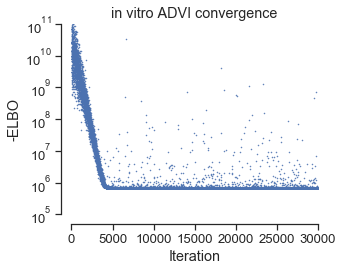

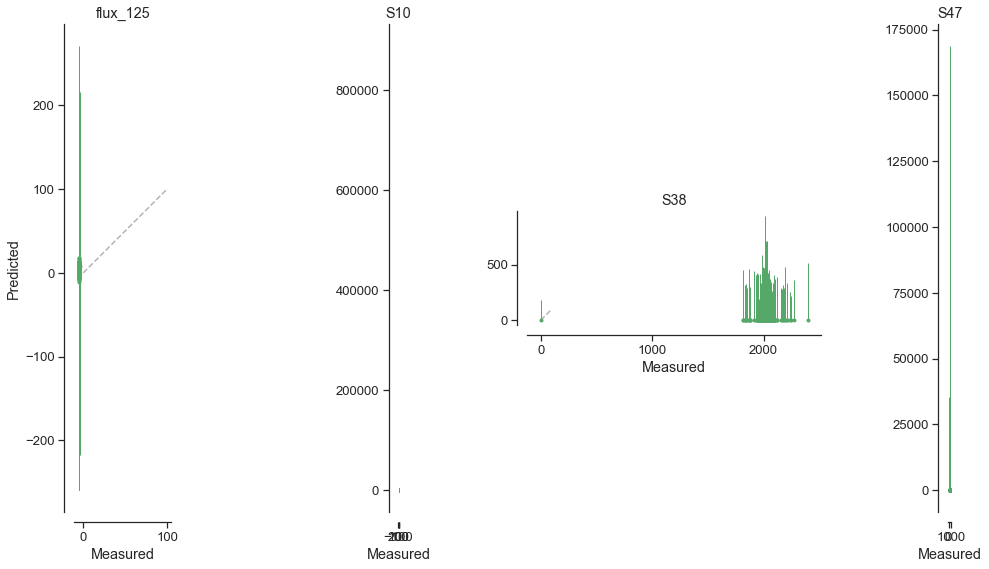

In [ ]:
# this plot is for comparing measured and posterior predicted values of metabolite concentrations and flux
with sns.plotting_context('notebook', font_scale=1.2):

    fig, axmatrix = plt.subplots(ncols=4, figsize=(16,8))
    # 6 columns, 1 for each internal species, 1 for each terminal flux

    for ax in axmatrix.flatten():
        ax.set_aspect('equal')

    def plot_hpd_err(truth, ppc, ax, color=None):
        median = np.median(ppc, 0) # (28, 6)
        hpd = pm.hpd(ppc)
        err = np.abs(hpd - median[:, np.newaxis])
        return ax.errorbar(truth, median, yerr=err.T, ls='',marker='.', elinewidth=1., color=color)

    # ADVI analysis
    plot_hpd_err(v['flux_125'].values, v_star[3] * ppc_vi['v_hat_obs'][:,:,3], axmatrix[0], 'g')
    
    plot_hpd_err(x['S10'].values, x_star[0] * np.exp(ppc_vi['chi_obs'][:,:,0]), axmatrix[1], 'g')
    plot_hpd_err(x['S38'].values, x_star[1] * np.exp(ppc_vi['chi_obs'][:,:,1]), axmatrix[2], 'g')
    plot_hpd_err(x['S47'].values, x_star[2] * np.exp(ppc_vi['chi_obs'][:,:,2]), axmatrix[3], 'g')
        
    # plt.suptitle(f'{script_name}: {dataset_name}', y=0.7)

    axmatrix[0].set_title('flux_125')
    axmatrix[1].set_title('S10')
    axmatrix[2].set_title('S38')
    axmatrix[3].set_title('S47')
    
    axmatrix[0].set_ylabel('Predicted')
    axmatrix[0].set_xlabel('Measured')
    axmatrix[1].set_xlabel('Measured')
    axmatrix[2].set_xlabel('Measured')
    axmatrix[3].set_xlabel('Measured')
    
    fig.tight_layout()

    ax0 = [0, 100]
    # axmatrix[0].set_ylim(ax0)
    axmatrix[0].plot(ax0, ax0, '--', color='.7', zorder=0)
    
    ax1 = [0, 100]
    #axmatrix[1].set_ylim(ax1)
    axmatrix[1].plot(ax1, ax1, '--', color='.7', zorder=0)

    ax2 = [0, 100]
    #axmatrix[1].set_ylim(ax1)
    axmatrix[2].plot(ax2, ax2, '--', color='.7', zorder=0)

    ax3 = [0, 100]
    #axmatrix[3].set_ylim(ax1)
    axmatrix[3].plot(ax3, ax3, '--', color='.7', zorder=0)

    
    sns.despine(trim=False, offset=10) # gets rid of the boxing
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

    #fig.savefig(f'advi_graphs/{script_name}-{dataset_name}-pcc_predictions.svg')

Here we calculate the flux control coefficients for both the ADVI and NUTS posteriors

NameError: name 'fcc_df' is not defined

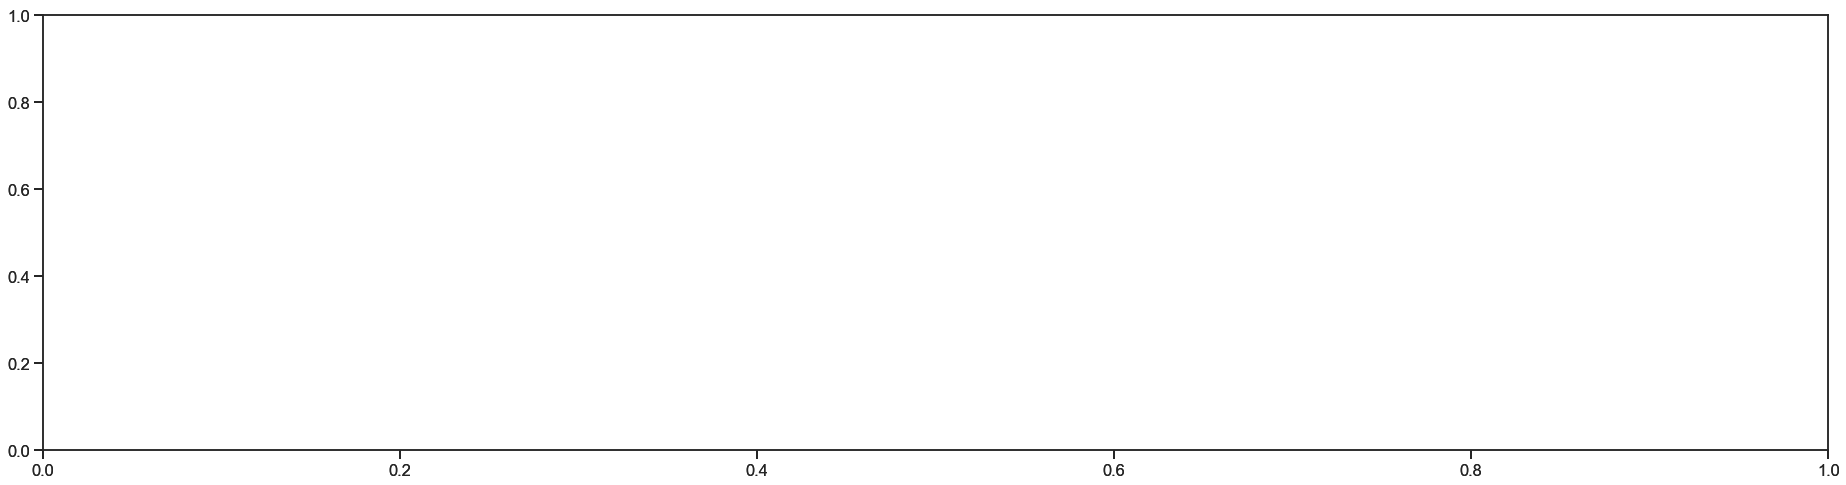

# Making a better graph of the FCCs
Here I attempt to find 20 highest magnitude values from the ADVI algorithm and compare them with the 20 highest magnitude values that are known from the ground truth

In [ ]:
#fcc_df.reset_index(inplace=True) ## you can only run this line once!

a = pd.pivot_table(fcc_df, values='FCC', index=['index'], columns=['Reaction'])
b = a.apply(pm.hpd).dropna()
b.to_csv(f'CSVs/{script_name}-{dataset_name}-FCCs_hpd.csv')
c = b.abs().transpose()
predicted_20 = c.nlargest(20, [0]).index.values

## WHERE IS J0??????????

compare medians with hpds

In [ ]:
c.nlargest(20, [0])

,0
Reaction,
J59,0.499960
J32,0.499918
J71,0.499915
J140,0.499913
J113,0.499902
J108,0.499902
J127,0.499867
J60,0.499863
J31,0.499844


In [ ]:
abs_gt_FCCs = res =  [abs(ele) for ele in gt_FCCs]
actual_20 = sorted(range(len(abs_gt_FCCs)), key=lambda i: abs_gt_FCCs[i])[-20:]
for a in actual_20:
    print(a, abs_gt_FCCs[a])

50 0.157
137 0.157
62 0.159
141 0.163
68 0.17
51 0.176
78 0.226
106 0.228
79 0.248
97 0.277
121 0.332
146 0.421
133 0.49
9 0.5
91 0.51
67 0.605
71 0.7
140 0.703
92 0.72
0 0.971


making the violin plot again, but with hpds instead of priors

*the plot below is not yet correct nor complete*

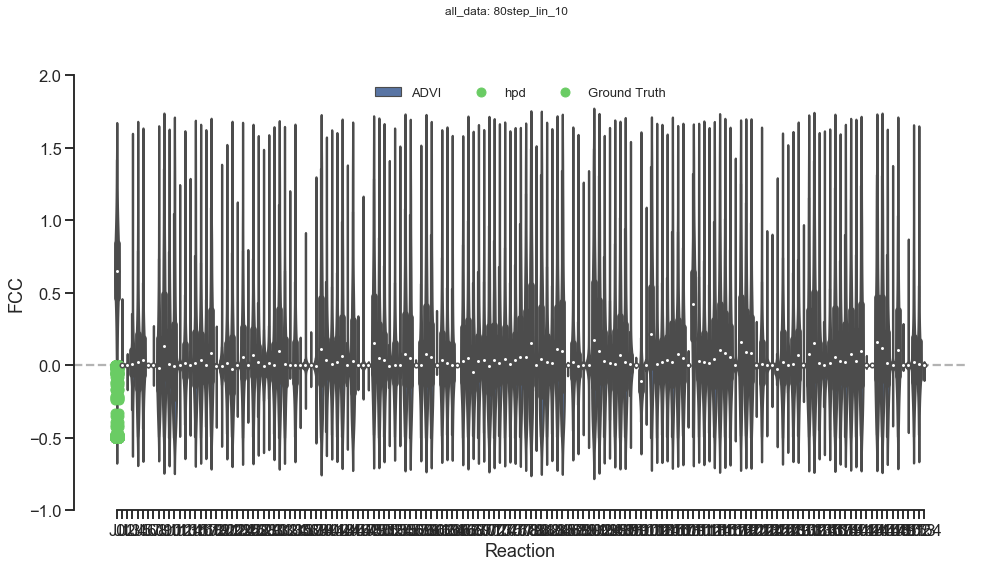

In [ ]:
fig = plt.figure(figsize=(16, 8))

my_pal = {"ADVI":"b"}

ax = fig.add_subplot(111)

plt.setp(ax.lines, color='.8')
plt.setp(ax.collections, alpha=.5, label="")

sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=fcc_df,
    scale='width', width=0.8, hue_order=['ADVI'],
    legend=False, palette=my_pal, zorder=3, ax=ax)

ADVI_hpd = b.values.tolist()
for i, cc in enumerate(ADVI_hpd):
    h = plt.plot([i - .4, i + .4], [cc, cc], 'o', color=sns.color_palette('muted')[2])

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()

ax.legend(handles + h + l, labels + ['hpd'] + ['Ground Truth'], loc='upper center', ncol=4, fontsize=13)
ax.set_ylim([-1, 2])

ax.axhline(0, ls='--', color='.7', zorder=0)
sns.despine(trim=True)

plt.suptitle(f'{script_name}: {dataset_name}', y=1)

fig.savefig(f'advi_graphs/{script_name}-{dataset_name}-FCCs_hpd_noPrior.svg', transparent=True)

In [ ]:
"""
import matplotlib.lines as mlines
vi_line = mlines.Line2D([], [], color='.6', ls='--', label='ADVI')

fig, axmatrix = plt.subplots(nrows=2, sharex=False, figsize=(10,5))
    
colors = sns.color_palette('husl', n_colors=e_all_vi.shape[-1])

for i, color in enumerate(colors[:ex_vi.shape[1]]):
    sns.kdeplot(ex_vi[:, i], ls='--', color=color, ax=axmatrix[0])
    
gt_Ex = [-0.63379, 1.04209, -0.491646, 1.21774, -0.782689, 1.12016, -0.694251, 1.14085, 1.42235]
for l in gt_Ex: # plot the ground truth values 
    axmatrix[0].axvline(l, 0, 1) 

axmatrix[0].set_xlim([-1, 1.5])
axmatrix[0].set_title('$\epsilon_x^*$')
axmatrix[0].set_ylabel('Frequency')
axmatrix[0].legend(handles=[vi_line], loc='upper right')

for i, color in enumerate(colors[ex_vi.shape[1]:]):
    sns.kdeplot(ey_vi[:, i], ls='--', color=color, ax=axmatrix[1])

gt_Ey = [0.9843063874738285, -0.9649533503183951, -1.1953481808173634]
for l in gt_Ey: # plot the ground truth values 
    axmatrix[1].axvline(l, 0, 1) 

axmatrix[1].set_xlim([-1.5, 1.5])
axmatrix[1].set_title('$\epsilon_y^*$')
axmatrix[1].set_ylabel('Frequency')


plt.tight_layout()
sns.despine(trim=True, offset=5)
fig.savefig(f'advi_graphs/{script_name}-{dataset_name}-elasticityDistributions.svg', transparent=True)"""

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000024346479378> (for post_execute):


KeyboardInterrupt: 